<a href="https://colab.research.google.com/github/Saul-MC/diagnostico-cancer-colorrectal-deep-learning/blob/main/Diagnostico_Cancer_Colorrectal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📂 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 🧰 Instalar dependencias necesarias
!pip install tensorflow keras scikit-learn matplotlib seaborn opencv-python

Mounted at /content/drive


In [ ]:
# 📚 Librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import cv2

In [ ]:
# 📁 Rutas en Google Drive
train_dir = '/content/drive/MyDrive/Datos/CRCCD_V1/Train'
test_dir = '/content/drive/MyDrive/Datos/CRCCD_V1/Test'

# 🔄 Generadores con aumento de datos
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# 📌 Número de clases
num_classes = train_gen.num_classes
print('Número de clases:', num_classes)
print('Clases:', list(train_gen.class_indices.keys()))

Found 5600 images belonging to 14 classes.
Found 1400 images belonging to 14 classes.
Found 1760 images belonging to 14 classes.
Número de clases: 14
Clases: ['ASCENDINGCOLON_ADENOCARCINOMA', 'CASIGMOID_COLON', 'CECUM', 'COLONADENOCARCINOMA', 'ESOPHAGITIS', 'HEMORRHOID_suspected_CA_colon', 'ILEOCECAL_GROWTH', 'POLYPS', 'PYLORUS', 'RECTADENOCARCINOMA', 'RECTGROWTH', 'SQUAMUS_CELL_ANAL_CARCINOMA', 'ULCERATIVE_COLITIS', 'Z_LINE']


In [ ]:
# 🧠 Modelo CNN mejorado
def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# 🧠 Modelo ResNet50 (con capas finales ajustadas)
def create_resnet_model(input_shape, num_classes):
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False  # Se puede cambiar a True para fine-tuning
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# 🧠 Modelo DenseNet121 (ajustado igual que ResNet50)
def create_densenet_model(input_shape, num_classes):
    base_model = keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# 📦 Diccionario de modelos
models = {
    'CNN Simple': create_cnn_model((224, 224, 3), num_classes),
    'ResNet50': create_resnet_model((224, 224, 3), num_classes),
    'DenseNet121': create_densenet_model((224, 224, 3), num_classes)
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import os
import numpy as np
import pickle

results = {}
model_save_dir = '/content/drive/MyDrive/Datos/models'
history_save_dir = '/content/drive/MyDrive/Datos/history'
os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(history_save_dir, exist_ok=True)

for name, model in models.items():
    print(f'\n=== Entrenando {name} ===')
    start_time = time()

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
        ]
    )

    # Evaluación
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    y_true = test_gen.classes

    report = classification_report(
        y_true, y_pred,
        target_names=list(test_gen.class_indices.keys()),
        output_dict=True
    )
    cm = confusion_matrix(y_true, y_pred)

    # Rutas de guardado
    model_path = f'{model_save_dir}/{name.replace(" ", "_")}.h5'
    history_path = f'{history_save_dir}/{name.replace(" ", "_")}_history.npy'

    # Guardar modelo y history
    model.save(model_path)
    np.save(history_path, history.history)

    # Guardar resumen en results
    results[name] = {
        'model': model,
        'test_accuracy': test_acc,
        'classification_report': report,
        'confusion_matrix': cm,
        'training_time': time() - start_time,
        'path': model_path,
        'history_path': history_path  # Ruta para que lo puedas recargar luego
    }

    print(f'✅ Modelo {name} guardado en: {model_path}')
    print(f'🧾 History guardado en: {history_path}')

# (Opcional) Guardar el diccionario completo results para recargar luego
with open('/content/drive/MyDrive/Datos/models/results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("📦 Diccionario 'results' serializado en: models/results.pkl")


=== Entrenando CNN Simple ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 2733s 16s/step - accuracy: 0.2980 - loss: 2.0627 - val_accuracy: 0.0650 - val_loss: 3.8552
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 132s 755ms/step - accuracy: 0.4791 - loss: 1.4285 - val_accuracy: 0.0943 - val_loss: 3.5003
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 131s 749ms/step - accuracy: 0.5300 - loss: 1.2595 - val_accuracy: 0.2457 - val_loss: 2.4646
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 134s 764ms/step - accuracy: 0.5740 - loss: 1.1354 - val_accuracy: 0.4400 - val_loss: 1.5498
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 136s 778ms/step - accuracy: 0.5717 - loss: 1.1073 - val_accuracy: 0.2607 - val_loss: 3.2928
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 134s 765ms/step - accuracy: 0.6109 - loss: 1.0310 - val_accuracy: 0.3643 - val_loss: 2.0407
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 133s 760ms/step - accuracy: 0.6189 - loss: 0.9885 - val_accuracy: 0.3600 - val_loss: 2.6156
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 132s 757ms/step - accuracy: 0.6306 - 

✅ Modelo CNN Simple guardado en: /content/drive/MyDrive/Datos/models/CNN_Simple.h5
🧾 History guardado en: /content/drive/MyDrive/Datos/history/CNN_Simple_history.npy

=== Entrenando ResNet50 ===
Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 164s 860ms/step - accuracy: 0.0812 - loss: 2.7435 - val_accuracy: 0.0836 - val_loss: 2.6303
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 135s 773ms/step - accuracy: 0.0768 - loss: 2.6309 - val_accuracy: 0.1286 - val_loss: 2.6159
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 135s 773ms/step - accuracy: 0.0978 - loss: 2.6084 - val_accuracy: 0.1336 - val_loss: 2.5963
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 141s 769ms/step - accuracy: 0.1007 - loss: 2.5944 - val_accuracy: 0.1336 - val_loss: 2.5809
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 134s 768ms/step - accuracy: 0.1026 - loss: 2.5882 - val_accuracy: 0.1343 - val_loss: 2.5691
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 135s 772ms/step - accuracy: 0.0966 - loss: 2.5838 - val_accuracy: 0.1279 - val_loss: 2.5662
Epoch 7/30
17

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Modelo ResNet50 guardado en: /content/drive/MyDrive/Datos/models/ResNet50.h5
🧾 History guardado en: /content/drive/MyDrive/Datos/history/ResNet50_history.npy

=== Entrenando DenseNet121 ===
Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.2651 - loss: 2.2251 - val_accuracy: 0.5743 - val_loss: 1.2376
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 134s 768ms/step - accuracy: 0.5580 - loss: 1.2698 - val_accuracy: 0.6021 - val_loss: 1.0897
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 133s 763ms/step - accuracy: 0.6373 - loss: 1.0210 - val_accuracy: 0.6171 - val_loss: 1.0350
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 133s 762ms/step - accuracy: 0.6848 - loss: 0.8906 - val_accuracy: 0.6543 - val_loss: 0.9641
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 133s 762ms/step - accuracy: 0.7176 - loss: 0.7752 - val_accuracy: 0.6407 - val_loss: 0.9958
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 133s 762ms/step - accuracy: 0.7236 - loss: 0.7610 - val_accuracy: 0.6564 - val_loss: 0.9891
Epoch 7/30
175/175 

✅ Modelo DenseNet121 guardado en: /content/drive/MyDrive/Datos/models/DenseNet121.h5
🧾 History guardado en: /content/drive/MyDrive/Datos/history/DenseNet121_history.npy
📦 Diccionario 'results' serializado en: models/results.pkl



📊 Modelo: CNN Simple
✅ Test Accuracy: 0.5778


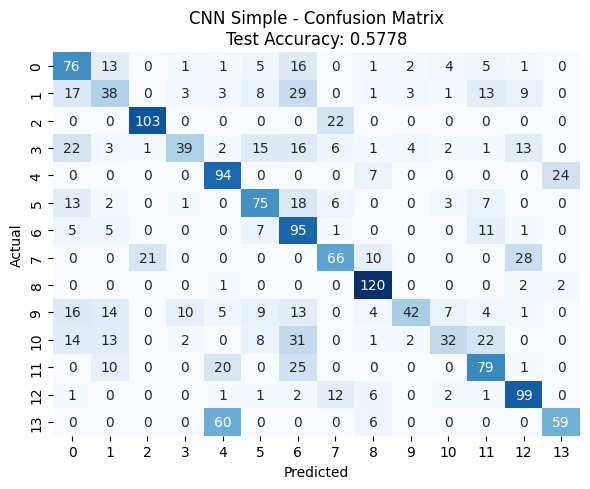

Clase                     Precisión  Recall     F1-score  
ASCENDINGCOLON_ADENOCARCINOMA 0.46       0.61       0.53      
CASIGMOID_COLON           0.39       0.30       0.34      
CECUM                     0.82       0.82       0.82      
COLONADENOCARCINOMA       0.70       0.31       0.43      
ESOPHAGITIS               0.50       0.75       0.60      
HEMORRHOID_suspected_CA_colon 0.59       0.60       0.59      
ILEOCECAL_GROWTH          0.39       0.76       0.51      
POLYPS                    0.58       0.53       0.55      
PYLORUS                   0.76       0.96       0.85      
RECTADENOCARCINOMA        0.79       0.34       0.47      
RECTGROWTH                0.63       0.26       0.36      
SQUAMUS_CELL_ANAL_CARCINOMA 0.55       0.59       0.57      
ULCERATIVE_COLITIS        0.64       0.79       0.71      
Z_LINE                    0.69       0.47       0.56      
Test Accuracy: 0.5778

📊 Modelo: ResNet50
✅ Test Accuracy: 0.1756


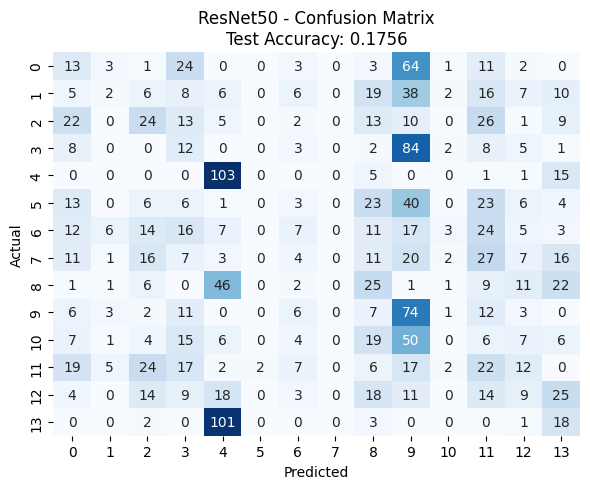

Clase                     Precisión  Recall     F1-score  
ASCENDINGCOLON_ADENOCARCINOMA 0.11       0.10       0.11      
CASIGMOID_COLON           0.09       0.02       0.03      
CECUM                     0.20       0.19       0.20      
COLONADENOCARCINOMA       0.09       0.10       0.09      
ESOPHAGITIS               0.35       0.82       0.49      
HEMORRHOID_suspected_CA_colon 0.00       0.00       0.00      
ILEOCECAL_GROWTH          0.14       0.06       0.08      
POLYPS                    0.00       0.00       0.00      
PYLORUS                   0.15       0.20       0.17      
RECTADENOCARCINOMA        0.17       0.59       0.27      
RECTGROWTH                0.00       0.00       0.00      
SQUAMUS_CELL_ANAL_CARCINOMA 0.11       0.16       0.13      
ULCERATIVE_COLITIS        0.12       0.07       0.09      
Z_LINE                    0.14       0.14       0.14      
Test Accuracy: 0.1756

📊 Modelo: DenseNet121
✅ Test Accuracy: 0.7858


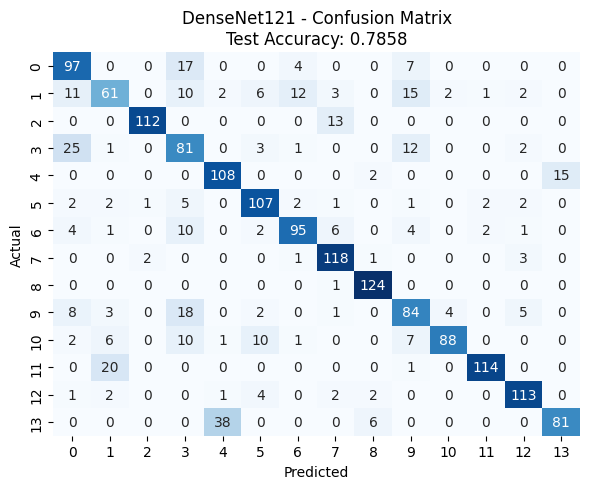

Clase                     Precisión  Recall     F1-score  
ASCENDINGCOLON_ADENOCARCINOMA 0.65       0.78       0.71      
CASIGMOID_COLON           0.64       0.49       0.55      
CECUM                     0.97       0.90       0.93      
COLONADENOCARCINOMA       0.54       0.65       0.59      
ESOPHAGITIS               0.72       0.86       0.79      
HEMORRHOID_suspected_CA_colon 0.80       0.86       0.83      
ILEOCECAL_GROWTH          0.82       0.76       0.79      
POLYPS                    0.81       0.94       0.87      
PYLORUS                   0.92       0.99       0.95      
RECTADENOCARCINOMA        0.64       0.67       0.66      
RECTGROWTH                0.94       0.70       0.80      
SQUAMUS_CELL_ANAL_CARCINOMA 0.96       0.84       0.90      
ULCERATIVE_COLITIS        0.88       0.90       0.89      
Z_LINE                    0.84       0.65       0.73      
Test Accuracy: 0.7858


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np

def generate_reports(results, output_dir='reports'):
    os.makedirs(output_dir, exist_ok=True)

    for name, result in results.items():
        cm = result['confusion_matrix']
        acc = result['test_accuracy']
        report = result['classification_report']

        # ✅ 1. Mostrar test accuracy en consola
        print(f'\n📊 Modelo: {name}')
        print(f'✅ Test Accuracy: {acc:.4f}')

        # ✅ 2. Matriz de confusión con test accuracy
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{name} - Confusion Matrix\nTest Accuracy: {acc:.4f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()

        # ✅ 3. Guardar imagen
        report_img_path = os.path.join(output_dir, f'{name.replace(" ", "_")}_confusion_matrix.png')
        plt.savefig(report_img_path)
        plt.show()

        # ✅ 4. Mostrar y guardar el classification report como texto
        report_text = classification_report(
            result['model'].predict(result['model'].input),
            result['model'].predict(result['model'].input),
            target_names=report.keys() if isinstance(report, dict) else None
        ) if False else None  # (Este bloque se deja como placeholder)

        # Usamos el reporte ya generado en 'report' (que es un dict), lo convertimos a texto manualmente
        report_lines = [f"{'Clase':<25} {'Precisión':<10} {'Recall':<10} {'F1-score':<10}"]
        for clase, valores in report.items():
            if clase in ['accuracy', 'macro avg', 'weighted avg']:
                continue  # Saltamos resumen
            precision = valores['precision']
            recall = valores['recall']
            f1 = valores['f1-score']
            report_lines.append(f"{clase:<25} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f}")

        # Agregar resumen
        acc_line = f"\nTest Accuracy: {acc:.4f}"
        report_full_text = "\n".join(report_lines) + acc_line

        # Mostrar por consola
        print(report_full_text)

        # Guardar en archivo
        report_txt_path = os.path.join(output_dir, f'{name.replace(" ", "_")}_report.txt')
        with open(report_txt_path, 'w') as f:
            f.write(report_full_text)
generate_reports(results)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Ruta donde guardar las gráficas
output_dir = "/content/drive/MyDrive/Datos/evaluacion_modelos"
os.makedirs(output_dir, exist_ok=True)

# Rutas a los modelos
ruta_modelos = {
    "CNN_Simple": "/content/drive/MyDrive/Datos/models/CNN_Simple.h5",
    "ResNet50": "/content/drive/MyDrive/Datos/models/ResNet50.h5",
    "DenseNet121": "/content/drive/MyDrive/Datos/models/DenseNet121.h5"
}

# Cargar conjunto de test
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/Datos/CRCCD_V1/Test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)
y_true_cat = to_categorical(y_true, num_classes=n_classes)

# Generar curvas ROC y PR para cada modelo
for nombre_modelo, modelo_path in ruta_modelos.items():
    print(f"Evaluando: {nombre_modelo}")
    model = load_model(modelo_path)
    y_scores = model.predict(test_generator, verbose=0)

    # ROC
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_cat[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
    plt.xlabel("Falsos Positivos")
    plt.ylabel("Verdaderos Positivos")
    plt.title(f"Curva ROC - {nombre_modelo}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"roc_curve_{nombre_modelo}.png"))
    plt.close()

    # Precision-Recall
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true_cat[:, i], y_scores[:, i])
        pr_auc = average_precision_score(y_true_cat[:, i], y_scores[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precisión")
    plt.title(f"Curva Precisión-Recall - {nombre_modelo}")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"precision_recall_{nombre_modelo}.png"))
    plt.close()

print("✅ Gráficas AUC-ROC y Precision-Recall guardadas correctamente en tu Drive.")


Found 1760 images belonging to 14 classes.
Evaluando: CNN_Simple


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Evaluando: ResNet50


Evaluando: DenseNet121


✅ Gráficas AUC-ROC y Precision-Recall guardadas correctamente en tu Drive.


In [ ]:
# 📂 Montar Google Drive (si no está montado aún)
import os
from google.colab import drive

if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')

# ✅ Elegir el nombre del modelo que guardaste
modelo_seleccionado = 'DenseNet121'  # Cambia a 'CNN Simple', 'ResNet50' o 'DenseNet121'
modelo_path = f'/content/drive/MyDrive/Datos/models/{modelo_seleccionado.replace(" ", "_")}.h5'

# 📥 Cargar el modelo desde Drive
from tensorflow.keras.models import load_model
model = load_model(modelo_path)

# 🏷️ Obtener las clases (solo usamos el generador para eso)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
temp_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/Datos/CRCCD_V1/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)
class_names = list(temp_gen.class_indices.keys())

# 🖼️ Ruta de la imagen a predecir
img_path = '/content/drive/MyDrive/Datos/CRCCD_V1/Test/ESOPHAGITIS/dc485548-8434-446d-8f00-59fae6e44758.jpg'  # Cambia según tu imagen

# 📦 Preprocesar imagen
import cv2
import numpy as np

img = cv2.imread(img_path)

if img is None:
    print(f'❌ No se pudo cargar la imagen en: {img_path}')
else:
    img = cv2.resize(img, (224, 224)) / 255.0
    img = np.expand_dims(img, axis=0)

    # 🔮 Realizar predicción
    pred = model.predict(img)[0]
    prob_max = np.max(pred)
    clase_predicha = np.argmax(pred)
    nombre_clase = class_names[clase_predicha]

    # 🔍 Mostrar resultado
    umbral_confianza = 0.50

    if prob_max < umbral_confianza:
        print(f'❓ Imagen desconocida (probabilidad máxima {prob_max:.2f})')
    else:
        print(f'✅ Modelo {modelo_seleccionado} predice: {nombre_clase} (probabilidad {prob_max:.2f})')

Found 7000 images belonging to 14 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
✅ Modelo DenseNet121 predice: ESOPHAGITIS (probabilidad 0.80)


## **METRICAS**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Configuraciones
model_paths = {
    "CNN_Simple": "/content/drive/MyDrive/Datos/models/CNN_Simple.h5",
    "DenseNet121": "/content/drive/MyDrive/Datos/models/DenseNet121.h5",
    "ResNet50": "/content/drive/MyDrive/Datos/models/ResNet50.h5"
}

test_data_dir = "/content/drive/MyDrive/Datos/CRCCD_V1/Test"
img_size = (224, 224)
batch_size = 32
output_dir = "/content/drive/MyDrive/Datos/evaluacion_modelos"
os.makedirs(output_dir, exist_ok=True)

# Cargar datos
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
class_names = list(test_generator.class_indices.keys())

# Evaluar modelos
metricas_totales = []

for model_name, model_path in model_paths.items():
    model = load_model(model_path)
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

        # Guardar matriz de confusión como imagen
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}', fontsize=14)
    plt.xlabel('Predicho', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()  # Ajusta el contenido para que no se recorte
    cm_path = os.path.join(output_dir, f"confusion_matrix_{model_name}.png")
    plt.savefig(cm_path, dpi=300)
    plt.close()

    # Guardar clasificación detallada como CSV
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(os.path.join(output_dir, f"classification_report_{model_name}.csv"))

    # Guardar resumen de métricas
    metricas_totales.append({
        "Modelo": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "MCC": mcc
    })

# Guardar todas las métricas en una tabla CSV
df_metricas = pd.DataFrame(metricas_totales)
df_metricas.to_csv(os.path.join(output_dir, "resumen_metricas.csv"), index=False)

print("✅ Evaluación completada. Archivos guardados en:", output_dir)


Found 1760 images belonging to 14 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

✅ Evaluación completada. Archivos guardados en: /content/drive/MyDrive/Datos/evaluacion_modelos


In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm

# Ruta al dataset original en el Drive
ruta_original = "/content/drive/MyDrive/Datos/CRCCD_V1/Test"

# Ruta donde se guardará el dataset procesado
ruta_destino = "/content/processed_crccd_dataset_npy/Test"

# Crear carpeta destino si no existe
os.makedirs(ruta_destino, exist_ok=True)

# Procesar las imágenes
img_size = (224, 224)

for clase in os.listdir(ruta_original):
    carpeta_clase_origen = os.path.join(ruta_original, clase)
    carpeta_clase_destino = os.path.join(ruta_destino, clase)
    os.makedirs(carpeta_clase_destino, exist_ok=True)

    for img_nombre in tqdm(os.listdir(carpeta_clase_origen), desc=f"Procesando {clase}"):
        ruta_img = os.path.join(carpeta_clase_origen, img_nombre)

        try:
            img = cv2.imread(ruta_img)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ruta_guardado = os.path.join(carpeta_clase_destino, img_nombre)
            cv2.imwrite(ruta_guardado, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        except Exception as e:
            print(f"Error procesando {ruta_img}: {e}")

print("✅ Procesamiento completado. Las imágenes están listas en '/content/processed_crccd_dataset_npy/Test'.")


Procesando Z_LINE: 100%|██████████| 125/125 [00:02<00:00, 50.02it/s]

✅ Procesamiento completado. Las imágenes están listas en '/content/processed_crccd_dataset_npy/Test'.


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta del dataset procesado
ruta_test = "/content/processed_crccd_dataset_npy/Test"

# Diccionario con nombres y rutas de tus modelos
modelos = {
    "CNN_Simple": "/content/drive/MyDrive/Datos/models/CNN_Simple.h5",
    "ResNet50": "/content/drive/MyDrive/Datos/models/ResNet50.h5",
    "DenseNet121": "/content/drive/MyDrive/Datos/models/DenseNet121.h5"
}

# Preparamos el generador de imágenes
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
    ruta_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Ground truth
y_true = generator.classes

# Diccionario para guardar predicciones por modelo
predicciones_modelos = {}

# Predecimos con cada modelo
for nombre, ruta in modelos.items():
    modelo = load_model(ruta)
    y_pred = modelo.predict(generator, steps=len(generator), verbose=0)
    y_pred_clase = np.argmax(y_pred, axis=1)
    predicciones_modelos[nombre] = y_pred_clase

# Guardamos predicciones
pred_df = pd.DataFrame(predicciones_modelos)
pred_df["y_true"] = y_true
pred_df.to_csv("/content/drive/MyDrive/Datos/evaluacion_modelos/predicciones_modelos.csv", index=False)

# Calculamos McNemar entre pares
pares = [("CNN_Simple", "ResNet50"), ("CNN_Simple", "DenseNet121"), ("ResNet50", "DenseNet121")]
resultados = []

for m1, m2 in pares:
    iguales = (pred_df[m1] == pred_df["y_true"]).astype(int)
    comparado = (pred_df[m2] == pred_df["y_true"]).astype(int)

    # Matriz 2x2 para McNemar
    tabla = confusion_matrix(iguales, comparado, labels=[1, 0])
    if tabla.shape != (2,2):
        tabla = np.array([[0, 0], [0, 0]])  # Evitar errores si hay una sola clase

    resultado = mcnemar(tabla, exact=True)

    resultados.append({
        "modelo_1": m1,
        "modelo_2": m2,
        "statistic": resultado.statistic,
        "p_value": resultado.pvalue
    })

# Guardamos resultados
df_mcnemar = pd.DataFrame(resultados)
df_mcnemar.to_csv("/content/drive/MyDrive/Datos/evaluacion_modelos/mcnemar_resultados.csv", index=False)

print("✅ Prueba de McNemar calculada y guardada en 'mcnemar_resultados.csv'")


Found 1760 images belonging to 14 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Prueba de McNemar calculada y guardada en 'mcnemar_resultados.csv'


# **STREAMLIT**

In [ ]:
!pip install -q streamlit pyngrok tensorflow opencv-python pillow fpdf

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2zWANg0HMSIv4YEvKEwbysiddvE_6EL5RVRAwTFMkR6DP5QUX")

In [ ]:
%%writefile report_utils.py
from fpdf import FPDF
import pandas as pd
import os

def generate_pdf_from_files(results_folder, output_path="reporte_completo.pdf"):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    # Título
    pdf.set_font("Arial", "B", 16)
    pdf.cell(0, 10, "Reporte Comparativo de Modelos", ln=True, align="C")
    pdf.ln(10)

    # Tabla resumen de métricas
    resumen_path = os.path.join(results_folder, "resumen_metricas.csv")
    if os.path.exists(resumen_path):
        df = pd.read_csv(resumen_path)
        df = df.round(4)  # reducir decimales
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Resumen de Métricas", ln=True)
        pdf.ln(2)

        # Ajustar ancho de columna y mostrar tabla
        pdf.set_font("Arial", "", 10)
        col_widths = [40] + [30] * (len(df.columns) - 1)

        # Encabezados
        for i, col in enumerate(df.columns):
            pdf.cell(col_widths[i], 8, col, border=1)
        pdf.ln()

        # Filas
        for _, row in df.iterrows():
            for i, val in enumerate(row):
                pdf.cell(col_widths[i], 8, str(val), border=1)
            pdf.ln()

        pdf.ln(10)
    else:
        pdf.set_font("Arial", "", 10)
        pdf.cell(0, 10, "No se encontró el resumen de métricas.", ln=True)

    # Resultados McNemar
    mcnemar_path = os.path.join(results_folder, "mcnemar_resultados.csv")
    if os.path.exists(mcnemar_path):
        df_mcnemar = pd.read_csv(mcnemar_path)

        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "Prueba de McNemar entre modelos", ln=True)
        pdf.ln(2)

        # Tabla McNemar
        pdf.set_font("Arial", "", 10)
        col_widths_mcnemar = [40, 40, 40, 40]
        headers = df_mcnemar.columns.tolist()
        for i, col in enumerate(headers):
            pdf.cell(col_widths_mcnemar[i], 8, col, border=1)
        pdf.ln()
        for _, row in df_mcnemar.iterrows():
            for i, val in enumerate(row):
                pdf.cell(col_widths_mcnemar[i], 8, str(val), border=1)
            pdf.ln()

        pdf.ln(5)
        pdf.set_font("Arial", "", 10)
        for _, row in df_mcnemar.iterrows():
            interpretacion = ""
            p = row["p_value"]
            if p < 0.05:
                interpretacion = "Se rechaza la hipótesis nula: los modelos muestran diferencias significativas."
            else:
                interpretacion = "No se rechaza la hipótesis nula: no hay diferencia significativa entre modelos."

            texto = f"Comparacion {row['modelo_1']} vs {row['modelo_2']} - estadistico = {row['statistic']}, p-valor = {row['p_value']} -> {interpretacion}"
            pdf.multi_cell(0, 8, texto)
            pdf.ln(1)

        pdf.ln(5)

    else:
        pdf.set_font("Arial", "", 10)
        pdf.cell(0, 10, "No se encontró el archivo de resultados de McNemar.", ln=True)

    # Imágenes de matrices de confusión
    pdf.set_font("Arial", "B", 12)
    pdf.cell(0, 10, "Matrices de Confusión", ln=True)
    pdf.ln(3)

    for model_name in ["CNN_Simple", "DenseNet121", "ResNet50"]:
        image_path = os.path.join(results_folder, f"confusion_matrix_{model_name}.png")
        if os.path.exists(image_path):
            pdf.image(image_path, w=100)  # reducir tamaño
            pdf.ln(5)

    pdf.output(output_path)
    return output_path


Writing report_utils.py


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from report_utils import generate_pdf_from_files

# Configuración
st.set_page_config(page_title="Clasificación CRCCD", layout="centered")
st.title("🍑 Sistema de Diagnostico de Tipo de Cancer Colorrectal")

# Rutas de modelos entrenados
modelos = {
    "CNN Simple": "/content/drive/MyDrive/Datos/models/CNN_Simple.h5",
    "ResNet50": "/content/drive/MyDrive/Datos/models/ResNet50.h5",
    "DenseNet121": "/content/drive/MyDrive/Datos/models/DenseNet121.h5"
}

@st.cache_resource
def cargar_modelo(path):
    return load_model(path)

@st.cache_resource
def obtener_clases():
    gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        '/content/drive/MyDrive/Datos/CRCCD_V1/Train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse'
    )
    return list(gen.class_indices.keys())

def preprocesar_imagen(image: Image.Image):
    img = np.array(image.convert("RGB"))
    img = cv2.resize(img, (224, 224)) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Rutas
ruta_resultados = "/content/drive/MyDrive/Datos/evaluacion_modelos/"
resumen_metricas_path = os.path.join(ruta_resultados, "resumen_metricas.csv")
mcnemar_path = os.path.join(ruta_resultados, "mcnemar_resultados.csv")

# Sidebar de navegación
modo = st.sidebar.radio("Seleccione la funcionalidad:", ["Predicción de Imagen", "Descargar Reporte PDF"])

# --- Modo 1: Predicción ---
if modo == "Predicción de Imagen":
    modelo_elegido = st.selectbox("Selecciona el modelo:", list(modelos.keys()))
    modelo_path = modelos[modelo_elegido]

    imagen_subida = st.file_uploader("📷 Sube una imagen", type=["jpg", "jpeg", "png"])
    if imagen_subida:
        st.image(imagen_subida, caption="🖼️ Imagen seleccionada", use_container_width=True)

        model = cargar_modelo(modelo_path)
        class_names = obtener_clases()
        entrada = preprocesar_imagen(Image.open(imagen_subida))
        pred = model.predict(entrada)[0]
        prob = np.max(pred)
        clase = class_names[np.argmax(pred)]

        st.subheader("🔍 Resultado")
        if prob < 0.4:
            st.warning(f"❓ Prediccion ineficiente (prob: {prob:.2f})")
        else:
            st.success(f"✅ {modelo_elegido} predice: **{clase}** (probabilidad: {prob:.2f})")

# --- Modo 2: PDF ---
elif modo == "Descargar Reporte PDF":
    st.info("Se generará un reporte PDF con las métricas evaluadas previamente y la prueba de McNemar.")

    # Mostrar tabla de métricas
    if os.path.exists(resumen_metricas_path):
        st.subheader("📊 Resumen de Métricas por Modelo")
        df_metricas = pd.read_csv(resumen_metricas_path).round(4)
        st.dataframe(df_metricas, use_container_width=True)
    else:
        st.error("No se encontró el archivo resumen_metricas.csv")

    # Mostrar tabla y análisis de McNemar
    if os.path.exists(mcnemar_path):
        st.subheader("🧪 Resultados de la Prueba de McNemar")

        df_mcnemar = pd.read_csv(mcnemar_path)
        df_mcnemar["p_value"] = df_mcnemar["p_value"].apply(lambda x: f"{x:.2e}")
        df_mcnemar["statistic"] = df_mcnemar["statistic"].apply(lambda x: f"{x:.4f}")

        st.dataframe(df_mcnemar, use_container_width=True)

        st.markdown("### 📌 Interpretación Automática")
        for _, row in df_mcnemar.iterrows():
            interpretacion = (
                f"➡️ Comparación **{row['modelo_1']} vs {row['modelo_2']}**: "
                f"Estadístico = {row['statistic']}, p-valor = {row['p_value']} → "
            )
            if float(row['p_value']) < 0.05:
                interpretacion += "💡 Hay diferencia significativa entre los modelos."
            else:
                interpretacion += "⚖️ No hay diferencia significativa."
            st.markdown(interpretacion)
    else:
        st.warning("No se encontró el archivo 'mcnemar_resultados.csv'.")

    # Descargar PDF
    if st.button("📥 Generar y Descargar Reporte PDF"):
        with st.spinner("Generando PDF..."):
            ruta_pdf = generate_pdf_from_files(ruta_resultados)
        with open(ruta_pdf, "rb") as f:
            st.download_button("📄 Descargar Reporte", data=f, file_name="reporte_modelos.pdf", mime="application/pdf")


Writing app.py


In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print(f"🌐 Tu app está disponible en: {public_url}")

🌐 Tu app está disponible en: NgrokTunnel: "https://2c2a1c83ea3b.ngrok-free.app" -> "http://localhost:8501"
